In [18]:
from pathlib import Path
import json
from tqdm import tqdm, trange

import torch
import nibabel as nib
from sklearn.model_selection import KFold

from slice_inflate.datasets.clinical_cardiac_views import replace_sp_tensor_values, get_sub_sp_tensor, display_clinical_views, get_clinical_cardiac_view_affines
from slice_inflate.utils.nifti_utils import crop_around_label_center


In [28]:
C3D = "/home/weihsbach/storage/staff/christianweihsbach/c3d/c3d-1.4.0-Linux-gcc64/bin/c3d"
MRXCAT_BASE_PATH = "../../data/datasets/MRXCAT"

assert Path(MRXCAT_BASE_PATH).is_dir()

split_file_path = Path(MRXCAT_BASE_PATH, 'prepared_files/metadata/data_split.json')
split_file_path.parent.mkdir(exist_ok=True, parents=True)
metadata_file_path = Path(MRXCAT_BASE_PATH, 'prepared_files/metadata/metadata.json')


mrx_cat_class_dict = dict(
    MYO=1, # -> 1
    LV=5,# -> 2
    RV=6,# -> 3
    LA=7,# -> 4
    RA=8# -> 5
)

target_class_dict = dict(
    MYO=1,
    LV=2,
    RV=3,
    LA=4,
    RA=5
)

all_cases = set([1,2,3,4,6,7,8,9])

# Plan B
test_cases = [2]
train_cases = all_cases - set(test_cases)
train_cases = list(train_cases)

phantom_time_frames = {
    "1": [range(20), set(range(40,68))-set((63,))], # Err at file 63
    "2": [range(32)],
    "3": [-1],
    "4": [range(20)], # has only 20 time frames
    "6": [-1],
    "7": [-1],
    "8": [-1],
    "9": [-1],
}

NUM_FOLDS = 3

# Crop images

In [20]:
if False:
    image_files = list(Path(MRXCAT_BASE_PATH).glob('**/phantom_*/*_texture/phantom.nii.gz'))
    label_files = list(Path(MRXCAT_BASE_PATH).glob('**/phantom_*/*_labels/phantom_act.nii.gz'))

    for cs_id in tqdm(all_cases, desc='case'):
        phantom_img = filter(lambda e: f"phantom_{cs_id:03d}" in str(e), image_files)
        phantom_label = filter(lambda e: f"phantom_{cs_id:03d}" in str(e), label_files)

        phantom_img_list = list(phantom_img)
        phantom_label_list = list(phantom_label)

        if phantom_img_list and phantom_label_list:
            for file in phantom_label_list + phantom_img_list:
                is_label = 'label' in str(file)

                nii = nib.load(file)
                nii_affine = nii.affine
                if is_label:
                    nii_data = torch.as_tensor(nii.get_fdata()).int()
                else:
                    nii_data = torch.as_tensor(nii.get_fdata()).float()
                del nii

                type_str = 'label' if is_label else 'image'
                for rng in tqdm(phantom_time_frames[str(cs_id)], desc='range'):
                    for t_idx in tqdm(rng, desc=f'frame_{type_str}'):
                        frame = nii_data[...,t_idx]

                        if is_label:
                            sp_frame = frame.to_sparse()

                            # Adjust the label values
                            sp_frame = get_sub_sp_tensor(sp_frame, mrx_cat_class_dict.values())
                            sp_frame = replace_sp_tensor_values(sp_frame,
                                                                existing_values=mrx_cat_class_dict.values(),
                                                                new_values=target_class_dict.values()
                            )
                            frame = sp_frame.to_dense()

                        target_path = Path(MRXCAT_BASE_PATH, 'prepared_files', f'phantom_{cs_id:03d}',
                                        f'phantom_{cs_id:03d}_t{t_idx:03d}_{type_str}.nii.gz').resolve()
                        target_path.parent.mkdir(exist_ok=True)
                        nib.save(nib.Nifti1Image(frame.numpy(), affine=nii_affine), target_path)
                        # break # debug

        # break # debug


case:   0%|          | 0/8 [00:00<?, ?it/s]




















frame_label: 100%|██████████| 20/20 [01:46<00:00,  5.34s/it]





























range: 100%|██████████| 2/2 [04:25<00:00, 132.64s/it]





















frame_image: 100%|██████████| 20/20 [01:25<00:00,  4.25s/it]





























case:  12%|█▎        | 1/8 [12:47<1:29:35, 767.96s/it]
































range: 100%|██████████| 1/1 [03:06<00:00, 186.54s/it]

































case:  25%|██▌       | 2/8 [24:39<1:13:29, 734.89s/it]




















range: 100%|██████████| 1/1 [01:46<00:00, 106.86s/it]





















case: 100%|██████████| 8/8 [28:26<00:00, 213.31s/it]  


# Split dataset

In [31]:
def filter_paths_for_cases_frames(paths, cases, for_nnunet=False):
    paths = sorted(paths)
    filtered = []
    for c in cases:
        ranges = phantom_time_frames[str(c)]
        if c == 1 and for_nnunet:
            frames = ranges[0]
        elif c == 1 and not for_nnunet:
            frames = ranges[1]
        else:
            frames = ranges[0]
        case_filtered = list(filter(
            lambda _path: \
                str(f"phantom_{c:03d}") in str(_path) \
                    and any([str(f"t{f:03d}") in str(_path) for f in frames]),
                paths))
        filtered.extend(case_filtered)
        filtered = [str(f) for f in filtered]
    return filtered

def get_fold_idxs_dict(paths):
    paths = sorted(paths)
    img_idxs = torch.arange(len(paths))[::2] # Every second path is an image

    cnks = torch.stack(torch.split(img_idxs, img_idxs.numel()//NUM_FOLDS)[:NUM_FOLDS])
    folds = []
    for f_idx in range(NUM_FOLDS):
        val_idxs = cnks.roll(f_idx, dims=0)[0]
        train_idxs = cnks.roll(f_idx, dims=0)[1:].flatten()
        folds.append((train_idxs, val_idxs))

    fold_dct = dict()
    for idx,f in enumerate(folds):
        train_idxs = sorted(f[0].tolist() + (f[0]+1).tolist())
        val_idxs = sorted(f[1].tolist() + (f[1]+1).tolist())
        fold_dct[f"fold_{idx}"] = dict(train_idxs=train_idxs, val_idxs=val_idxs)
    return fold_dct

if True:
    prepared_paths = list(Path(MRXCAT_BASE_PATH).resolve().glob('prepared_files/**/*.nii.gz'))

    nnunet_train_paths = filter_paths_for_cases_frames(prepared_paths, train_cases, for_nnunet=True)
    train_paths = filter_paths_for_cases_frames(prepared_paths, train_cases)
    test_paths = filter_paths_for_cases_frames(prepared_paths, test_cases)

    split_dict = dict(
        nnunet_train_files=nnunet_train_paths,
        train_files=train_paths,
        train_folds=get_fold_idxs_dict(train_paths),
        test_files=test_paths,
    )

    with open(split_file_path, 'w') as f:
        json.dump(split_dict, f, indent=4)

# Extract cardiac phases

In [22]:
if False:
    prepared_paths = list(Path(MRXCAT_BASE_PATH).resolve().glob('prepared_files/**/*.nii.gz'))

    label_paths = [p for p in prepared_paths if '_label.nii.gz' in str(p)]
    image_paths = [str(p).replace('_label.nii.gz', '_image.nii.gz') for p in label_paths]

    for lbl_p, img_p in tqdm(list(zip(label_paths, image_paths)), desc='pair'):
        nii_image = nib.load(img_p)
        nii_label = nib.load(lbl_p)
        volume_affine = torch.as_tensor(nii_label.affine)[None]
        label_data = torch.as_tensor(nii_label.get_fdata()).int()
        image_data = torch.as_tensor(nii_image.get_fdata())

        cropped_label, cropped_image, cropped_nii_affine = crop_around_label_center(
            label_data[None,None], volume_affine, fov_mm=torch.tensor([256.,256.,256.]), fov_vox=torch.tensor([256,256,256]),
            image=image_data[None,None])

        nib.save(nib.Nifti1Image(cropped_label[0,0].int().numpy(), affine=cropped_nii_affine[0].numpy()), lbl_p)
        nib.save(nib.Nifti1Image(cropped_image[0,0].numpy(), affine=cropped_nii_affine[0].numpy()), img_p)

pair: 100%|██████████| 100/100 [15:36<00:00,  9.37s/it]


# Extract clinical views

  0%|          | 0/238 [00:00<?, ?it/s]

phantom_001_t000_image


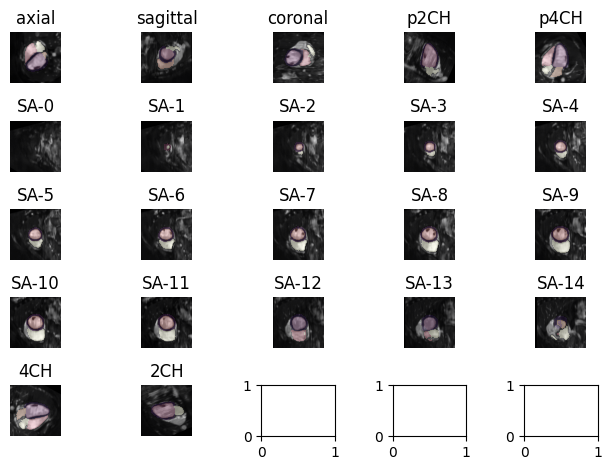

  1%|          | 2/238 [00:08<17:23,  4.42s/it]

 17%|█▋        | 40/238 [01:32<06:45,  2.05s/it]

phantom_004_t000_image


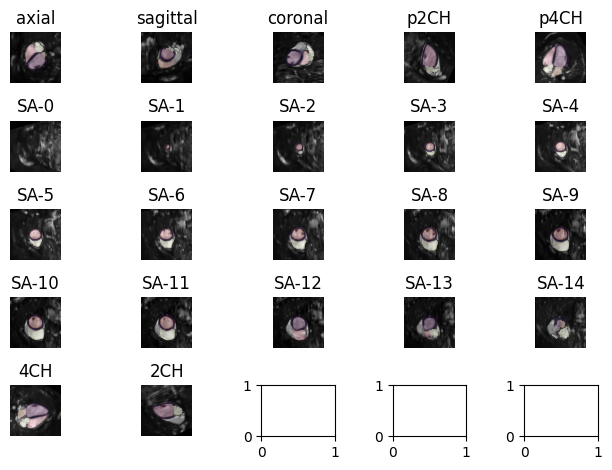

 18%|█▊        | 42/238 [01:42<09:44,  2.98s/it]

 34%|███▎      | 80/238 [03:17<05:42,  2.17s/it]

phantom_001_t040_image


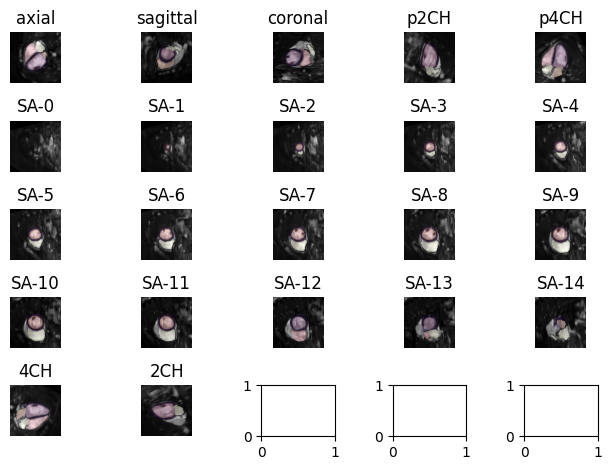

 34%|███▍      | 82/238 [03:37<11:38,  4.48s/it]

 50%|█████     | 120/238 [04:57<05:10,  2.63s/it]

phantom_001_t060_image


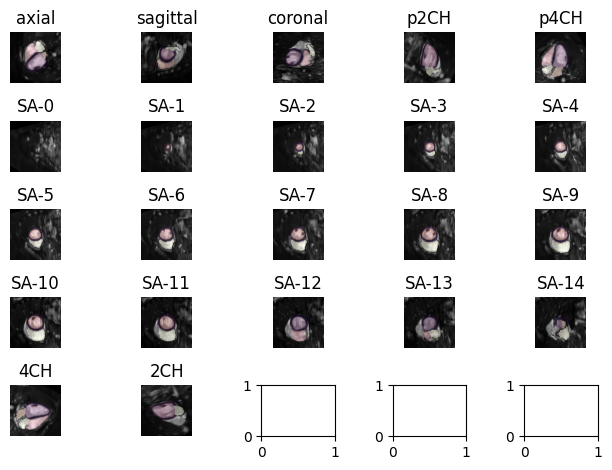

 51%|█████▏    | 122/238 [05:09<07:01,  3.63s/it]

 67%|██████▋   | 160/238 [06:42<02:33,  1.97s/it]

phantom_004_t013_image


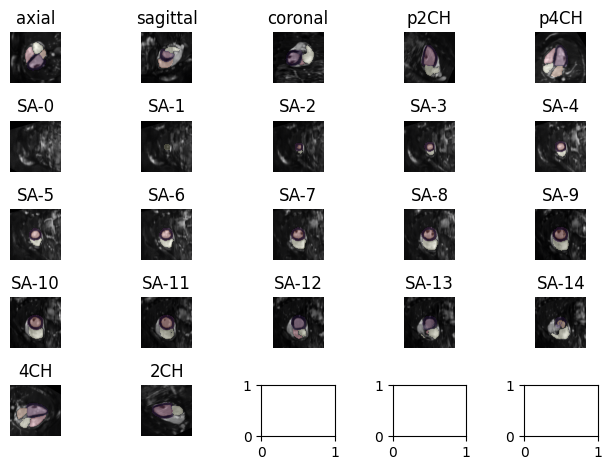

 68%|██████▊   | 162/238 [06:52<03:37,  2.86s/it]

 84%|████████▍ | 200/238 [07:54<00:55,  1.46s/it]

phantom_002_t013_image


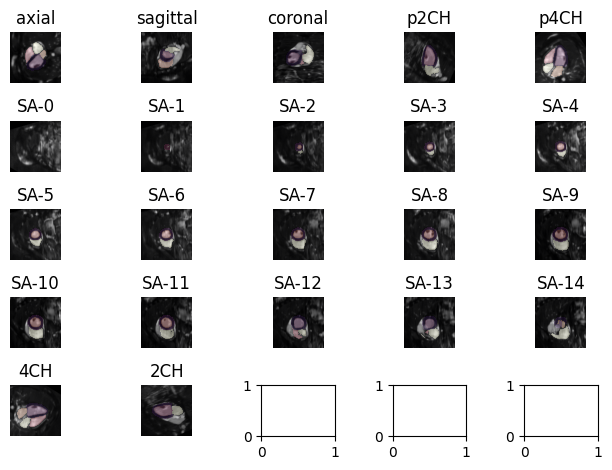

 85%|████████▍ | 202/238 [08:04<01:29,  2.48s/it]

100%|██████████| 238/238 [09:08<00:00,  2.30s/it]


In [36]:
NUM_SA_SLICES = 15

class_dict = dict(
    MYO=1,
    LV=2,
    RV=3,
    LA=4,
    RA=5
)

if False:
    display_idx = 0
    with open(split_file_path, 'r') as f:
        split_dict = json.load(f)

    prepared_paths = split_dict['nnunet_train_files'] + split_dict['train_files'] + split_dict['test_files']

    metadata_dict = dict()

    for nii_label_path in tqdm(prepared_paths):
        if not 'label' in nii_label_path: continue

        nii_image_path = nii_label_path.replace("label", "image")
        nii_label = nib.load(nii_label_path)
        nii_image = nib.load(nii_image_path)

        label = torch.as_tensor(nii_label.get_fdata()).int()
        sp_label = label.to_sparse()
        volume_affine = torch.as_tensor(nii_image.affine)
        volume = torch.as_tensor(nii_image.get_fdata())
        class_selected_sp_label = get_sub_sp_tensor(sp_label, eq_value=tuple(class_dict.values()))

        clinical_view_affines = get_clinical_cardiac_view_affines(
            class_selected_sp_label, volume_affine, class_dict, num_sa_slices=NUM_SA_SLICES, debug=False
        )

        unrolled_view_affines = {}
        for view_name, affine in clinical_view_affines.items():
            if view_name == 'ALL_SA':
                for a_idx, uaff in enumerate(affine):
                    unrolled_name = f'SA-{a_idx}'
                    unrolled_view_affines[unrolled_name] = uaff.tolist()
            else:
                unrolled_view_affines[view_name] = affine.tolist()

        image_id = nii_image_path.split('/')[-1].replace('.nii.gz', '')
        metadata_dict[image_id] = dict(view_affines=unrolled_view_affines)


        if display_idx % 20 == 0:
            # Print every 5th sample
            print(image_id)
            display_clinical_views(volume, class_selected_sp_label, volume_affine, class_dict, num_sa_slices=NUM_SA_SLICES, debug=False)
            print()
            print()

        display_idx +=1

    with open(metadata_file_path, 'w') as f:
        json.dump(metadata_dict, f, indent=4)